<a href="https://colab.research.google.com/github/klaasmeinke/CNNs-exoplanet-cartography/blob/main/Planet_Pixelization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive')
    %cd '/content/drive/MyDrive/Thesis'

from scipy import spatial as sp_spatial
%run Plotting.ipynb

Mounted at /content/drive
/content/drive/MyDrive/Thesis
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis


## Fibonacci Sphere

#### Create Fibonacci Spiral

In [ ]:
def fib_spiral(samples):
    points = []
    phi = np.pi * (3 - 5**0.5)  # golden angle in radians
    for i in range(samples):
        y = 1 - 2 * (i / (samples - 1))
        r = (1 - y **2) **0.5

        theta = phi * i

        x = r * np.cos(theta)
        z = r * np.sin(theta)

        points.append([x,y,z])

    return np.array(points)

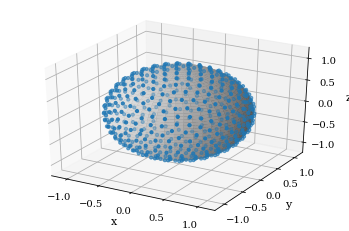

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.axes.set_xlim3d(left=-1.2, right=1.2)
ax.axes.set_ylim3d(bottom=-1.2, top=1.2)
ax.axes.set_zlim3d(bottom=-1.2, top=1.2)

# plot fibonacci points
points = fib_spiral(500)
ax.scatter(points[:,0], points[:,1], points[:,2], s=10)

# plot sphere: (taken from http://prancer.physics.louisville.edu/astrowiki/index.php/Graphics_with_Python)
u = np.linspace(0, 2 * np.pi, 300)
v = np.linspace(0, np.pi, 300)
x = 0.99*np.outer(np.cos(u), np.sin(v))
y = 0.99*np.outer(np.sin(u), np.sin(v))
z = 0.99*np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color=[0.9,0.9,0.9], alpha=1)

#### Make a Sphere out of the Points

In [ ]:
def fib_sphere(samples):

    points = fib_spiral(int(samples/2 + 2))
    hull = sp_spatial.ConvexHull(points)
    indices = hull.simplices
    faces = points[indices]

    return np.array(faces)

#### Plot

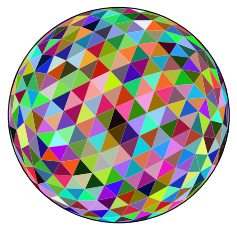

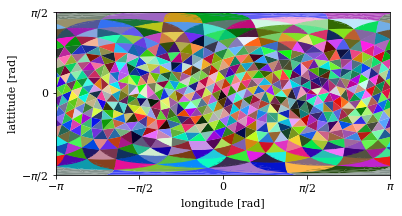

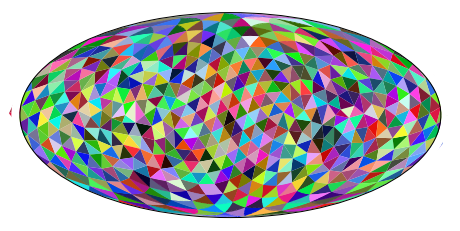

In [ ]:
faces = fib_sphere(768)
colors = [np.random.rand(3) for face in faces]

plot_disk(faces, colors)

plot_2d(faces, colors)
mollweide(faces, colors)

#### Normal Vectors

these are needed for calculating flux contributions from each face <br>
output vector has direction normal to face (out of planet) and magnitude equal to the area of the face <br>

In [ ]:
def normals(faces):
    li = []

    for i in range(len(faces)):
        f = faces[i]
        AB = f[1] - f[0]
        AC = f[2] - f[0]
        li.append(0.5 * np.cross(AB,AC)) # magnitude of this nromal is equal to area of the triangle

        x = np.mean(f[:,0]) # mean x value
        if x > 0:
            if np.dot(li[i],[1,0,0]) < 0:
                li[i] = -li[i]
        else:
            if np.dot(li[i],[1,0,0]) > 0:
                li[i] = -li[i]
    return(li)

#### Pixel Size Distribution
normals all have same magnitude as area of triangle (see normals function)

Text(0.5, 0, 'Area')

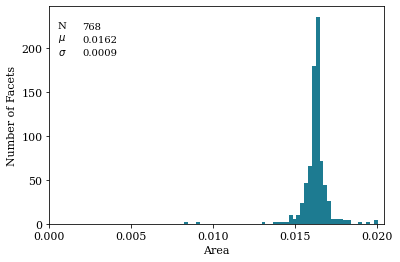

In [ ]:
faces = fib_sphere(768)
norms = normals(faces)

fib_areas = [np.linalg.norm(norm) for norm in norms]

bins = 50

fig = plt.figure(figsize = (6,4))
# plt.title('Areas of Fibonacci Sphere Facets')
plt.hist(fib_areas, bins = bins, color = '#1D7B91')
plt.xlim([0,max(fib_areas )*1.02])
fig.set_facecolor('white')

# labels = ['N', 'bins', 'mean', 'std', 'min', 'max']
# vals = [len(faces), bins, np.mean(fib_areas ), np.std(fib_areas ),
#         min(fib_areas ), max(fib_areas )]

labels = ['N', '$\mu$', '$\sigma$']
vals = [len(faces), np.mean(fib_areas), np.std(fib_areas )]
# vals = ['aight', 'aight', 'aight']

label_txt = ''
for label in labels:
    label_txt += label + '\n'

val_txt = ''
for val in vals:
    if type(val) != int:
        val = '%.4f' %val
    val_txt += str(val) + '\n'

plt.text(0.0005, 180, label_txt, linespacing=1.3)
plt.text(0.002, 177, val_txt, linespacing=1.6)

plt.xticks([0,0.005, 0.010, 0.0150, 0.02])
plt.ylabel('Number of Facets')
plt.xlabel('Area')

#### A list of the shortest edge of each face
this is used for tetrahedral subdivision

In [ ]:
def shortest_edges(faces):
    li = []
    for f in faces:
        AB = np.linalg.norm(f[1] - f[0])
        AC = np.linalg.norm(f[2] - f[0])
        BC =  np.linalg.norm(f[2] - f[1])
        li.append(min([AB, AC, BC]))
    return(li)

#### Save Faces, Normals, Coordinates and Shortest Edges for a 1000 Face Fibonacci Sphere

In [ ]:
faces100k = fib_sphere(100000)
norms100k = normals(faces100k)

np.save('data/faces100k', faces100k)
np.save('data/norms100k', norms100k)

In [ ]:
faces = fib_sphere(1000)
norms = normals(faces)
edges = shortest_edges(faces)
points = [face.mean(axis = 0) for face in faces]

np.save('data/faces', faces)
np.save('data/norms', norms)
np.save('data/edges', edges)
np.save('data/points', points)

## HealPix
this image is from Gorski 2005

<img src = 'https://docs.google.com/uc?export=download&id=1Q7h4K_GkQ0GX3TJT5mJcskZvi0BTDJe2'>

#### Create the Base Diamonds:

In [ ]:
def heal_base():
    # top row:
    top_row = [ [] for i in range(4) ]
    for i in range(4):
        top_row[i].append([ 0.25 + 0.5 * i, 0.5 ])
        top_row[i].append([ 0.5 * i, 0.25 ])
        top_row[i].append([ 0.25 + 0.5 * i, 0 ])
        top_row[i].append([ 0.5 + 0.5 * i, 0.25 ])

    # middle row:
    mid_row = [ [] for i in range(4) ]
    for i in range(4):
        mid_row[i].append([ 0.5 * i, 0.25 ])
        mid_row[i].append([ 0.25 + 0.5 * i, 0 ])
        mid_row[i].append([ 0.5 * i, -0.25 ])
        mid_row[i].append([ -0.25 + 0.5 * i, 0 ])

    # bottom row:
    bot_row = [ [] for i in range(4) ]
    for i in range(4):
        bot_row[i].append([ 0.25 + 0.5 * i, 0 ])
        bot_row[i].append([ 0.5 * i, -0.25 ])
        bot_row[i].append([ 0.25 + 0.5 * i, -0.5 ])
        bot_row[i].append([ 0.5 + 0.5 * i, -0.25 ])

    # stick them together:
    faces = np.vstack((top_row, mid_row, bot_row)) * np.pi

    return faces

#### Plot

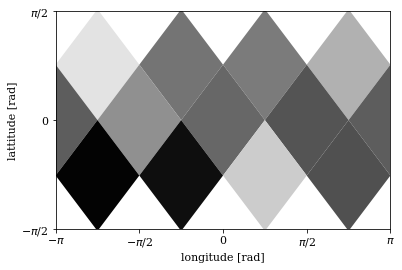

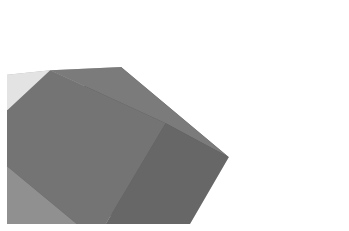

In [ ]:
faces_2d = heal_base()
faces_3d = [[geo2cart(point[0], point[1]) for point in face] for face in faces_2d]

colors = [np.random.rand() for face in faces_3d]
plot_2d(faces_3d, colors)
plot_3d(faces_3d, colors)

#### Split the Diamonds into more Diamonds

In [ ]:
def quadruple_diamonds(faces):
    faces_new = []

    for f in faces:
        faces_new.append([f[0], (f[0]+f[1])/2, (f[0]+f[2])/2, (f[0]+f[3])/2])
        faces_new.append([(f[0]+f[1])/2, f[1], (f[1]+f[2])/2, (f[0]+f[2])/2])
        faces_new.append([(f[0]+f[2])/2, (f[1]+f[2])/2, f[2], (f[2]+f[3])/2])
        faces_new.append([(f[0]+f[3])/2, (f[0]+f[2])/2, (f[2]+f[3])/2, f[3]])

    faces_new = np.array(faces_new)
    return np.array(faces_new)

def heal_faces(multiply):
    faces = heal_base()
    for i in range(multiply):
        faces = quadruple_diamonds(faces)

    for i in range(len(faces)): # iterate over faces
        for j in range(len(faces[0])): # iterate over points in face
            if abs(faces[i,j,1]) > 0.25*np.pi: # check is lattitude is above 0.25 pi or below -0.25 pi

                long = faces[i,j,0]
                h = abs(faces[i,j,1]) - np.pi/4

                for x in [0.25, 0.75, 1.25, 1.75]:
                    if x < long/np.pi < x+0.25:
                        faces[i,j,0] = x*np.pi + 0.25*np.pi*(long - x*np.pi)/(0.25*np.pi - h)

                    if x - 0.25 < long/np.pi < x:
                        faces[i,j,0] =  x*np.pi - 0.25*np.pi*(x*np.pi - faces[i,j,0])/(0.25*np.pi - h)

    return faces

#### Plot

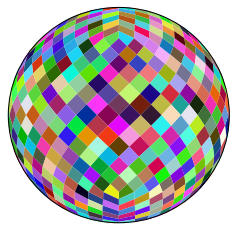

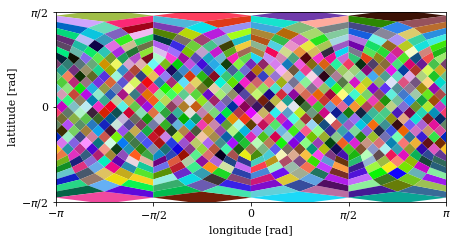

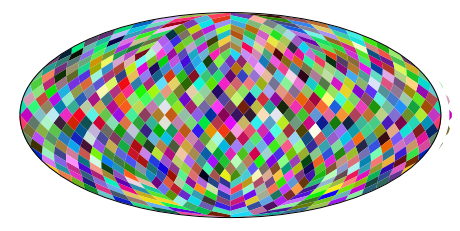

In [ ]:
faces_2d = heal_faces(3)
faces_3d = np.array([[geo2cart(point[0], point[1]) for point in face]
                     for face in faces_2d])

colors = [np.random.rand(3) for face in faces_3d]

plot_disk(faces_3d, colors = colors)
plot_2d(faces_3d, colors)
mollweide(faces_3d, colors)

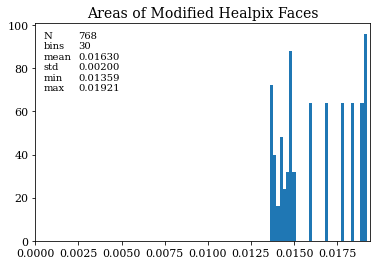

In [ ]:
faces_2d = heal_faces(3)
faces_3d = [[geo2cart(point[0], point[1]) for point in face] for face in faces_2d]

heal_areas = []

for face in np.array(faces_3d):
    # to calculate the area, split into two triangles
    area1 = 0.5 * np.linalg.norm(np.cross(face[0]-face[1], face[2]-face[1]))
    area2 = 0.5 * np.linalg.norm(np.cross(face[0]-face[3], face[2]-face[3]))
    heal_areas.append(area1 + area2)

bins = 30

fig = plt.figure()
fig.set_facecolor('white')
plt.title('Areas of Modified Healpix Faces')
plt.hist(heal_areas,bins=bins)
plt.xlim([0,np.max(heal_areas)*1.01])

labels = ['N', 'bins', 'mean', 'std', 'min', 'max']
vals = [len(faces_3d), bins, np.mean(heal_areas), np.std(heal_areas),
        min(heal_areas), max(heal_areas)]

label_txt = ''
for label in labels:
    label_txt += label + '\n'

val_txt = ''
for val in vals:
    if type(val) != int:
        val = '%.5f' %val
    val_txt += str(val) + '\n'

plt.text(0.0005, 65, label_txt)
plt.text(0.0025, 65, val_txt)
plt.show()

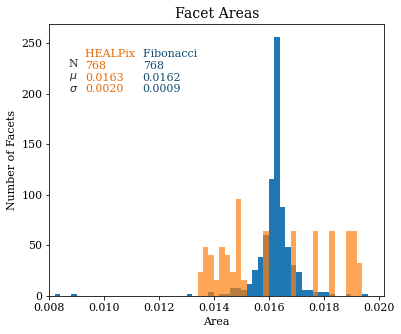

In [ ]:
fig = plt.figure(figsize=(6,5))
fig.set_facecolor('white')
bins = np.arange(0.008, 0.02, 0.0002)

plt.hist(fib_areas, bins, label='Fibonacci Sphere')
plt.hist(heal_areas, bins, alpha=0.7, label='Modified HEALPix')

labels = ['N', '$\mu$', '$\sigma$']#, 'min', 'max']

y = 190
x = 0.0087

label_txt = ''
for label in labels:
    label_txt += label + '\n'

plt.text(x, y, label_txt, fontsize = 11, color = '#282828')

for areas, x_plus, c, name in zip([heal_areas, fib_areas],
                       [0.0006, 0.0027],
                       ['#e56a00', '#144c73'],
                       ['HEALPix \n', 'Fibonacci \n']):

    vals = [len(areas), np.mean(areas), np.std(areas)]
            # min(areas), max(areas)]

    val_txt = name
    for val in vals:
        if type(val) != int:
            val = '%.4f' %val
        val_txt += str(val) + '\n'

    plt.text(x + x_plus, y, val_txt, color = c, fontsize = 11)

plt.xlim([0.008, 0.0202])
plt.title('Facet Areas')
plt.xlabel('Area')
plt.ylabel('Number of Facets')

# plt.legend(loc='lower left')
plt.show()